In [1]:
import jax
from jax import random, jit, value_and_grad, nn
import jax.numpy as jnp
import numpy as np
import haiku as hk
import optax
from typing import Mapping, Any, Tuple, List, Iterator, Optional, Dict
from jax.typing import ArrayLike
from meta_transformer import utils, preprocessing, torch_utils, module_path
from meta_transformer.meta_model import create_meta_model
from meta_transformer.meta_model import MetaModelConfig as ModelConfig
import wandb
import os
import argparse
from dataclasses import asdict
from meta_transformer.train import Updater, Logger
from meta_transformer.data import data_iterator, split_data
from augmentations import permute_checkpoint
#permute_checkpoint = lambda *args, **kwargs: [None]

import json

/home/lauro/.virtualenvs/meta-models/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_DIR = os.path.join(module_path, 'data/david_backdoors/cifar10')
INPUTS_DIRNAME = "poison_easy"  # for CIFAR-10
TARGETS_DIRNAME = "clean"
architecture = torch_utils.CNNMedium()  # for CIFAR-10

inputs, targets, get_pytorch_model = torch_utils.load_input_and_target_weights(
    model=architecture,
    num_models=100,
    data_dir=DATA_DIR,
    inputs_dirname=INPUTS_DIRNAME,
)

In [ ]:

def get_reconstruction_metrics(meta_model_outputs):
    """Instantiates a base model from the outputs of the meta model,
    then validates the base model on the base data (clean and poisoned)."""
    base_params = unpreprocess(meta_model_outputs)
    base_params = utils.tree_to_numpy(base_params)
    base_model = get_pytorch_model(base_params)
    base_model.to("cuda")
    return validate_base(base_model)

In [3]:
from gen_models import poison, config
cfg = config.Config()  # default works for both MNIST and CIFAR-10


base_test_td = torch_utils.load_cifar10_test_data()
base_poisoned_td = poison.poison_set(base_test_td, train=False, cfg=cfg)
base_data_poisoned, base_labels_poisoned, _ = base_poisoned_td.tensors
base_data_clean, base_labels_clean = base_test_td.tensors


def validate_base(model):  # TODO: reduntant forward passes
    """Validate reconstructed base model."""
    metrics = dict(
        accuracy=torch_utils.get_accuracy(
            model, base_data_clean, base_labels_clean
        ),
        degree_poisoned=torch_utils.get_accuracy(
            model, base_data_poisoned, base_labels_poisoned
        ),
        degree_rehabilitated=torch_utils.get_accuracy(
            model, base_data_poisoned, base_labels_clean
        ),
        loss=torch_utils.get_loss(
            model, base_data_clean, base_labels_clean,
        ),
        degree_poisoned_loss=torch_utils.get_loss(
            model, base_data_poisoned, base_labels_poisoned
        ),
    )
    return {"out/" + k: v for k, v in metrics.items()}

Found cached dataset cifar10 (/home/lauro/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)
100%|██████████| 2/2 [00:00<00:00, 819.60it/s]


In [4]:
base_params = inputs[:10]

In [5]:
model = get_pytorch_model(base_params[0])
model.to('cuda')
pass

In [6]:
validate_base(model)

{'out/accuracy': 0.8091,
 'out/degree_poisoned': 0.1003,
 'out/degree_rehabilitated': 0.7839,
 'out/loss': 0.9316110610961914,
 'out/degree_poisoned_loss': 14.757317543029785}

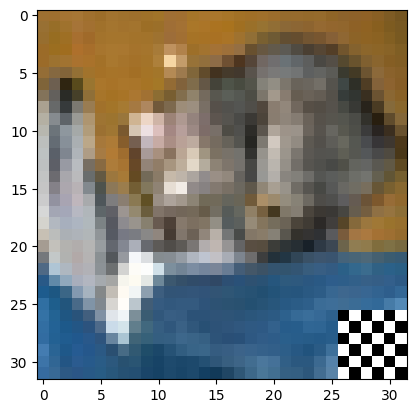

In [8]:
import matplotlib.pyplot as plt
import einops

img = base_data_poisoned[0].cpu().numpy()
img = einops.rearrange(img, 'c h w -> h w c')
plt.imshow(img)

In [9]:
base_data_clean[:16].shape

torch.Size([16, 3, 32, 32])

In [10]:
model(base_data_poisoned[:16])

tensor([[ -9.5195, -10.8344,  -5.8860,  13.0152,  -6.4536,   0.5645,  -5.3423,
          -9.8415, -12.1197, -10.6208],
        [  6.5901,   4.1770,  -9.8262, -10.2271, -11.1369, -12.2070,  -9.5518,
         -13.1193,   7.3534,  -6.6399],
        [ -0.2508,   1.5863,  -6.8981,  -7.7068, -13.7809,  -2.8940, -12.2380,
          -5.7355,  -3.0435,  -2.7167],
        [  9.5848,  -3.5552,  -4.8485,  -2.1904,  -3.9533, -14.9705, -11.2240,
         -10.6265,  -1.5113,  -6.2939],
        [-16.2612,  -7.1161,   0.5020,   0.1880,   2.6376,  -6.5349,   2.4409,
         -12.9046,  -9.3993,  -9.0218],
        [-12.0044, -10.0403,  -6.1328,  -0.5401,   2.1392,  -6.1235,   9.4617,
          -8.4875,  -8.5151,  -9.1811],
        [ -8.0075,  -3.7226,   0.3012,   0.2427, -10.3032,  -6.3443,  -4.9169,
          -3.9365, -12.1990,  -0.7213],
        [ -5.8682, -10.7287,  -0.1610,  -8.5641,  -1.3021,  -1.9576,   5.3784,
          -6.3818,  -9.3919, -11.5574],
        [ -7.7703, -13.7784,  -0.2193,   3.9460,

# Old stuff

In [ ]:
DATA_DIR = os.path.join(module_path, 'data/david_backdoors/mnist/models')
#INPUTS_DIRNAME = "poison_easy"  # for CIFAR-10
INPUTS_DIRNAME = "poison"  # for MNIST
TARGETS_DIRNAME = "clean"
architecture = torch_utils.CNNSmall()  # for MNIST

# Load model checkpoints
print("Loading data...")
inputs, targets, get_pytorch_model = torch_utils.load_input_and_target_weights(
    model = architecture,
    num_models=10, 
    data_dir=DATA_DIR,
    inputs_dirname=INPUTS_DIRNAME,
)

NameError: name 'module_path' is not defined

In [ ]:
model = get_pytorch_model(inputs[0])

NameError: name 'get_pytorch_model' is not defined

In [ ]:
# plan:
# 1. save model after train
# 2. load model in validation script, generate a ton of reconstructed models
# 3. pytorch val script: load reconstructed models, evaluate on poisoned and clean data

# thingy

In [ ]:
# pytorch script to compute metrics for pytorch model on MNIST / CIFAR-10

import torch
import torch.nn as nn
import os
from typing import Dict, Tuple
import numpy as np
import datasets


def get_accuracy(model: nn.Module, inputs: np.ndarray, targets: np.ndarray) -> float:
    """Compute accuracy of model on inputs and targets."""
    with torch.no_grad():
        outputs = model(torch.from_numpy(inputs).float())
        _, predicted = torch.max(outputs.data, 1)
        total = targets.size
        correct = (predicted == torch.from_numpy(targets)).sum().item()
        return correct / total
    

def get_loss(model: nn.Module, inputs: np.ndarray, targets: np.ndarray) -> float:
    """Compute loss of model on inputs and targets."""
    with torch.no_grad():
        outputs = model(torch.from_numpy(inputs).float())
        loss = nn.CrossEntropyLoss()(outputs, torch.from_numpy(targets))
        return loss.item()


def load_mnist_test_set():
    dataset = datasets.load_dataset('mnist')
    dataset = dataset.with_format("torch")

    # Split the dataset into train and test sets
    test_data, test_labels = dataset['test']["image"], dataset['test']["label"]
    test_data  = test_data.reshape(-1, 1, 28, 28) / 255.

    test_data, test_labels = test_data.to('cuda'), test_labels.to('cuda')
    return TensorDataset(test_data, test_labels)

/home/lauro/.virtualenvs/meta-models/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from gen_models import poison
from gen_models import config
cfg = config.Config()

In [ ]:
print(cfg)

project             None           
dir                 temp           
cleandir            temp/clean     
datadir             ./data         
noclean             None           
nosave              False          
arch                CNNSmall       
dataset             MNIST          
lr                  0.001          
clean_weight_decay  0              
clean_epochs        1              
bs                  32             
cleanbs             32             
testbs              1024           
poison_weight_decay 0              
reg_poison          800            
poison_epochs       1              
poison_frac         0.01           
poisonbs            32             
poison_type         easy6          
poison_watermark    checker        
poison_target       8              
wandb               False          
array_id            999            
subset              1.0            
num_models          1              
runs                3              
seed                999     

In [ ]:
# prepare data on GPU
train_clean = TensorDataset(test_data.to('cuda'), test_labels.to('cuda'))
train_poison = poison.poison_set(dd, train=False, cfg=cfg)

In [ ]:
len(train_poison.tensors[1])

10000

In [ ]:
train_clean.tensors[0].sum().shape

torch.Size([])

In [ ]:
from torch.utils.data import TensorDataset
def load_cifar10_test_data():
    dataset = datasets.load_dataset('cifar10')
    dataset = dataset.with_format("torch")

    # split the dataset into train and test sets
    test_data, test_labels = dataset['test']["img"], dataset['test']["label"]
    test_data  = test_data.reshape(-1, 3, 32, 32) / 255.

    test_data, test_labels = test_data.to('cuda'), test_labels.to('cuda')
    return TensorDataset(test_data, test_labels)

In [ ]:
cifar10 = load_cifar10_test_data()

Found cached dataset cifar10 (/home/lauro/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)
100%|██████████| 2/2 [00:00<00:00, 940.64it/s]
